Importação de bibliotecas necessárias

In [1]:
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
import json

In [2]:
import tensorflow as tf

from tensorflow.keras.layers import Embedding, Dense, Conv1D, MaxPooling1D, GlobalMaxPooling1D;
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow import keras

from tensorflow.keras.models import model_from_json

Verificação de uso de GPU 

In [3]:
from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13626076276200867905
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 5949620224
locality {
  bus_id: 1
  links {
  }
}
incarnation: 1829418597204930892
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3050, pci bus id: 0000:01:00.0, compute capability: 8.6"
xla_global_id: 416903419
]


In [4]:
from tensorflow.python.client import device_lib

def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]

print(get_available_devices())

['/device:CPU:0', '/device:GPU:0']


In [5]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [6]:
print(tf.__version__)

2.9.0


Abrindo os dados processados

In [7]:
with open("tokenizer.json", "r") as jsonfile:
    tokenizer = json.load(jsonfile)

tokenizer = tf.keras.preprocessing.text.tokenizer_from_json(tokenizer)

In [8]:
with open("dados/assuntoTratado.csv", "r") as csvfile:
    assuntos = np.genfromtxt(csvfile, delimiter=",")
    assuntos = assuntos.astype(np.int32)

In [9]:
with open("dados/conteudoTratado.csv", "r") as csvfile:
    conteudos = np.genfromtxt(csvfile, delimiter=",")
    conteudos = conteudos.astype(np.int32)

In [10]:
vocab = len(tokenizer.word_index)

In [11]:
maxContent = max(len(tokens) for tokens in conteudos)
maxSubject = len(np.unique(assuntos))

Gerando os valores categóricos das dummies

In [12]:
assuntos = pd.get_dummies(assuntos).values

Separação de dados entre treino, validação e teste. Cada separação de dados possuí todos os 5 valores categóricos diferentes, garantindo que todos sejam testados

In [13]:
size = len(conteudos)

#Treino: 70%
xTrain = conteudos[0:int(size*0.7)]
yTrain = assuntos[0:int(size*0.7)]

#Validação: 10%
xVal = conteudos[int(size*0.7):int(size*0.8)]
yVal = assuntos[int(size*0.7):int(size*0.8)]

#Teste: 20%
xTest = conteudos[int(size*0.8):]
yTest = assuntos[int(size*0.8):]

In [14]:
vocab

92754

In [15]:
model = Sequential()

model.add(Embedding(vocab, 256, input_length = maxContent)),
model.add(Conv1D(64, 3, activation = "relu")),
model.add(Conv1D(32, 3, activation = "relu")),
model.add(GlobalMaxPooling1D()),
model.add(Dense(5, activation = "softmax"))

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 5476, 256)         23745024  
                                                                 
 conv1d (Conv1D)             (None, 5474, 64)          49216     
                                                                 
 conv1d_1 (Conv1D)           (None, 5472, 32)          6176      
                                                                 
 global_max_pooling1d (Globa  (None, 32)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 5)                 165       
                                                                 
Total params: 23,800,581
Trainable params: 23,800,581
Non-trainable params: 0
____________________________________________

In [17]:
model.compile(optimizer="adam", loss = "categorical_crossentropy", metrics=["accuracy"])

In [18]:
subjectModel = 'modelo/subjectModel.h5'
subjectModelJson = 'modelo/subjectModel.json'

In [19]:
modeljson = model.to_json()
with open(subjectModelJson, 'w') as json_file:
  json_file.write(modeljson)

Funções de callback chamadas no treinamento

In [20]:
lr_reducer = ReduceLROnPlateau(monitor='val_accuracy', factor = 0.9, patience=3, verbose = 1)
#lr_reducer é uma função que diminui a taxa de aprendizado, quando o treinamento atinge um "plateau", ou uma linha reta no gráfico de validaton_loss

early_stopper = EarlyStopping(monitor='val_accuracy', min_delta=0, patience = 8, verbose = 1, mode = 'auto')
#early_stopper evita que o modelo treine épocas desnecessárias, ou seja, quando em 8 épocas neste caso, o modelo não avance significativamente na sua validation_loss, o treinamento para

checkpointer = ModelCheckpoint(subjectModel, monitor='val_accuracy', verbose = 1, save_best_only=True)
#o checkpointer garante que o modelo seja salvo constantemente durante o treinamento

Treinamento da rede neural, com 20 épocas, com batch_size único

In [21]:
neuralNetwork = model.fit(xTrain, yTrain, validation_data = (xVal, yVal), epochs=20, batch_size=1, callbacks=[lr_reducer,checkpointer])

Epoch 1/20
7072/7072 [==============================] - ETA: 0s - loss: 0.2733 - accuracy: 0.9079
Epoch 1: val_accuracy improved from -inf to 0.94065, saving model to modelo\subjectModel.h5
7072/7072 [==============================] - 134s 19ms/step - loss: 0.2733 - accuracy: 0.9079 - val_loss: 0.1834 - val_accuracy: 0.9407 - lr: 0.0010
Epoch 2/20
7072/7072 [==============================] - ETA: 0s - loss: 0.0964 - accuracy: 0.9688
Epoch 2: val_accuracy did not improve from 0.94065
7072/7072 [==============================] - 130s 18ms/step - loss: 0.0964 - accuracy: 0.9688 - val_loss: 0.3663 - val_accuracy: 0.8971 - lr: 0.0010
Epoch 3/20
7072/7072 [==============================] - ETA: 0s - loss: 0.0399 - accuracy: 0.9888
Epoch 3: val_accuracy did not improve from 0.94065
7072/7072 [==============================] - 128s 18ms/step - loss: 0.0399 - accuracy: 0.9888 - val_loss: 0.5173 - val_accuracy: 0.8981 - lr: 0.0010
Epoch 4/20
7071/7072 [============================>.] - ETA: 0s -

Plot do gráfico do avanço das variáveis de loss, e valdiation loss.

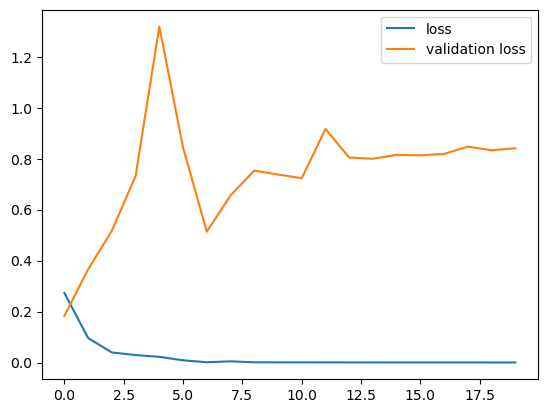

In [22]:
plt.plot(neuralNetwork.history['loss'], label = 'loss')
plt.plot(neuralNetwork.history["val_loss"], label = "validation loss")
plt.legend()

Plot do gráfico do avanço das variáveis de accuracy, e valdiation accuracy.

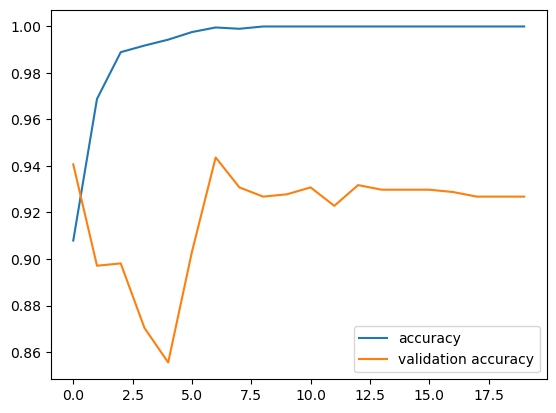

In [23]:
plt.plot(neuralNetwork.history['accuracy'], label = 'accuracy')
plt.plot(neuralNetwork.history["val_accuracy"], label = "validation accuracy")
plt.legend()

Recarregamento do modelo, para que não seja necessário executar o treinamento novamente toda vez que for necessário rodar trechos de código novamente

In [24]:
from tensorflow.keras.models import model_from_json

with open('modelo/subjectModel.json', 'r') as json_file:
  model = model_from_json(json_file.read())

model = tf.keras.models.load_model('modelo/subjectModel.h5')

Labels dos assuntos do banco de dados

In [25]:
assuntoTxt = ["economia", "esportes", "politica", "famosos","tecnologia"]

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 5476, 256)         23745024  
                                                                 
 conv1d (Conv1D)             (None, 5474, 64)          49216     
                                                                 
 conv1d_1 (Conv1D)           (None, 5472, 32)          6176      
                                                                 
 global_max_pooling1d (Globa  (None, 32)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 5)                 165       
                                                                 
Total params: 23,800,581
Trainable params: 23,800,581
Non-trainable params: 0
____________________________________________

Nas próximas linhas seguem exemplos de uma predição do modelo

In [27]:
idx = 0

In [28]:
inputPred = xTest[idx].reshape(1, maxContent)

In [29]:
#corpo do texto da notícia
tokenizer.sequences_to_texts(inputPred)

['logo após vencer sua quarta liga dos campeões com o real madrid o atacante cristiano ronaldo deu a entender que a vitória sobre o liverpool neste sábado pode ter sido sua última partida pelo clube espanhol o importante era ganhar e entrar na história isso era o importante agora é hora de aproveitar o momento vou comemorar e nos dias seguintes darei uma resposta aos torcedores que estão sempre do meu lado foi muito bonito estar no real madrid disse o camisa 7 ao canal bein sports o repórter perguntou então se a resposta era uma despedida e o craque fez mais mistério o programa el chiringuito de grande repercussão na espanha também abordou cristiano após a entrevista ao bein e o questionou se o craque tem dúvidas sobre o futuro não tenho dúvidas isso não é importante de verdade é hora de aproveitar descansar e ir para a seleção na próxima semana já veremos o que acontecerá o importante é a história que o real fez o camisa 7 aproveitou ainda a conversa com o el chiringuito para tirar on

In [30]:
prediction = model.predict(inputPred)

1/1 [==============================] - 0s 114ms/step


In [31]:
prediction

array([[3.2149077e-27, 1.0000000e+00, 2.3135769e-15, 4.6694724e-15,
        2.2205048e-20]], dtype=float32)

In [32]:
assuntoTxt[yTest[idx].argmax()]

'esportes'

In [33]:
assuntoTxt[prediction.argmax()]

'esportes'

In [34]:
scores = model.evaluate([xTest[0:2019]], [yTest[0:2019]])

64/64 [==============================] - 1s 16ms/step - loss: 0.8007 - accuracy: 0.9173


In [35]:
scores
#loss e accuracy, respectivamente

[0.8007087707519531, 0.9172857999801636]

tratamento de dados e geração de predições para a criação de uma matriz de confusão

In [36]:
yPred = []
for x in xTest:

    yPred.append(       
        model.predict(x.reshape(1, maxContent))[0].argmax()   
        )
    

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 14ms/step


In [37]:
yTestNumeric = []

for y in yTest:
    yTestNumeric.append(y.argmax())

In [38]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [39]:
confMatrix = confusion_matrix(yTestNumeric, yPred)

In [40]:
confMatrix

array([[403,   9,  39,   3,  35],
       [  0, 627,   0,   1,   1],
       [ 32,   3, 447,   1,   2],
       [  2,  14,   0, 211,   1],
       [  8,   8,   4,   5, 165]], dtype=int64)

Porcentagem de erro, respectivamente em cada um dos assuntos

In [41]:
totals = np.sum(confMatrix[:], axis=1)
trues = []

for i in range(5):
    trues.append(confMatrix[i][i])

(totals-trues)/totals*100

array([17.58691207,  0.31796502,  7.83505155,  7.45614035, 13.15789474])

Matriz de confusão

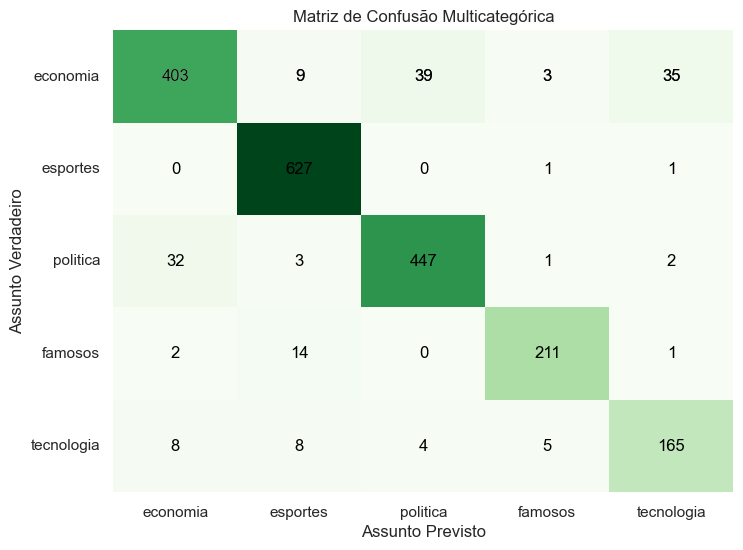

In [42]:
sns.set(style="whitegrid")

plt.figure(figsize=(8, 6))
heatmap = sns.heatmap(confMatrix, annot=True, fmt="d", cmap="Greens", cbar=False)

for i in range(len(confMatrix)):
    for j in range(len(confMatrix[i])):
        plt.text(j + 0.5, i + 0.5, confMatrix[i, j],
                 ha='center', va='center', color='black')

heatmap.set_xticklabels(assuntoTxt, rotation=0)
heatmap.set_yticklabels(assuntoTxt, rotation=0)

plt.title('Matriz de Confusão Multicategórica')
plt.xlabel('Assunto Previsto')
plt.ylabel('Assunto Verdadeiro')

plt.show()

In [43]:
assuntoTxt

['economia', 'esportes', 'politica', 'famosos', 'tecnologia']

Mostra cada os erros da rede baseado no assunto escolhido

In [44]:
for x in range(5):
    with open("dados/errosAssunto"+assuntoTxt[x]+".txt", "w") as file:
        for y in range(len(yPred)):
            if yPred[y] != yTestNumeric[y] and yTestNumeric[y] == x:
                texto = "{} \n[{} {}]\n\n".format(
                    tokenizer.sequences_to_texts([xTest[y]])[0],
                    assuntoTxt[yTestNumeric[y]],
                    assuntoTxt[yPred[y]]
                )                    

                file.write(texto)
